The emergence of clean-label dataset poisoning attacks has gained popularity in the present where correctly labeled poison samples are injected into the training dataset. The appearance of the poisoned sample do not raise questions to ordinary human eyes, but they contain malicious behaviour to trigger a targeted misclassification during inference. In this notebook we learn about transferable clean-label poisoning attack (known as Bullseye Polytope)
against transfer learning, which creates poison images (multiple images from different angles) with their
center close to the target image in the feature space.

# Creating Transferable Clean Label Attacks in ART with Bullseye Polytope Clean Label Attacks

In [1]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from art.estimators.classification import PyTorchClassifier
from art.attacks.poisoning import BullseyePolytopeAttackPyTorch

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


     plane       deer       ship        car


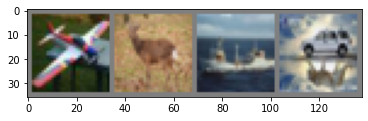

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))
base_labels = labels.numpy()

In [5]:
net = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10))


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
NUM_EPOCHS = 1
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 2.206
[1,  4000] loss: 1.851
[1,  6000] loss: 1.649
[1,  8000] loss: 1.575
[1, 10000] loss: 1.529
[1, 12000] loss: 1.460


In [8]:
classifier = PyTorchClassifier(net, loss, (3, 32, 32), 10, clip_values=(0,1), preprocessing=(0.5, 0.5))

In [9]:
target = images[0].unsqueeze(0)

In [10]:
attack = BullseyePolytopeAttackPyTorch(classifier, target.numpy(), 9)

In [11]:
poison, p_labels = attack.poison(images.numpy() / 2 + 0.5, base_labels)

  0%|          | 0/4000 [00:00<?, ?it/s]

     plane       deer       ship        car


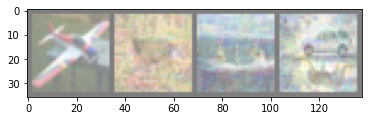

In [12]:
imshow(torchvision.utils.make_grid(torch.from_numpy(poison)))
print(' '.join('%10s' % classes[base_labels[j]] for j in range(4)))